<a href="https://colab.research.google.com/github/Varnez/final-degree-project/blob/master/notebooks/DCGAN_CIFAR10_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
    !nvidia-smi

Thu Jun 25 10:21:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Deep Convolutional Generative Adversarial Network in Pytorch

## Imports

In [ ]:
import os

import numpy as np

import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.datasets import CIFAR10

import matplotlib.pyplot as plt

from datetime import datetime

from tqdm.notebook import tqdm

In [ ]:
MODEL_STORAGE_FOLDER = './model_dumps'

# Explicit seed picking for the shake of reproducibility
seed = 42
random.seed(seed)
torch.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Data Preprocessing

In [ ]:
def normalize_real_images(real_images):
    min_value = real_images.min()
    max_value = real_images.max()

    normalized_images = 2 * (real_images - min_value) / (max_value - min_value) - 1

    return normalized_images

In [ ]:
# Data preprocessing to set the image values from range [0, 1] to [-1, 1]
preprocessing_ops = transforms.Compose([transforms.ToTensor()])

# Dataset download
train_dataset = CIFAR10(root="./data", train=True, transform=preprocessing_ops, download=True)
test_dataset = CIFAR10(root="./data", train=False, transform=preprocessing_ops, download=True)

# Class label of class to use for training (5 = dogs)
class_label = 5

# Obtain indices of given class instances
train_idx = np.where(np.array(train_dataset.targets) == class_label)
test_idx = np.where(np.array(test_dataset.targets) == class_label)

# Retrieve class instances
train_data = train_dataset.data[train_idx]
test_data = test_dataset.data[test_idx]

data = np.concatenate((train_data, test_data))

# Final dataset
real_images = torch.from_numpy(np.transpose(data, (0,3,1,2))).float()
real_images = normalize_real_images(real_images)

if torch.cuda.is_available():
    real_images = real_images.cuda()

print("\nReal image dataset preprocessed and readied, consisting in {} images".format(len(real_images)))

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified

Real image dataset preprocessed and readied, consisting in 6000 images


## Visualization

In [ ]:
def image_visualization_pretreatment(img):
    min = img.min()
    max = img.max()

    if not (min == 0 and img.max == 0):
        img -= min
        img /= max - min

    return img

In [ ]:
def visualize_batch(batch, save=False, epoch=0):
    batch = image_visualization_pretreatment(batch)
    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(batch, padding=2, normalize=False), (1,2,0)))

    if save:
        if not os.path.exists('./output/synth_imgs'):
            os.makedirs('./output/synth_imgs')
            
        plt.savefig("output/synth_imgs/{} : epoch {}.png".format(datetime.now().strftime("%H:%M:%S"), epoch))

    plt.show()

    

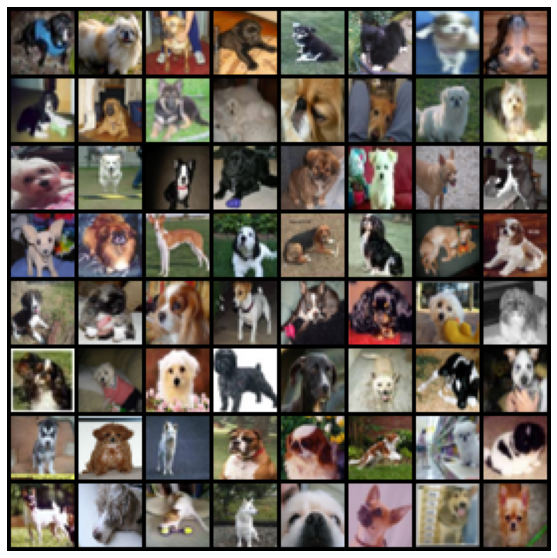

In [ ]:
# Real images exploration
visualization_batch = real_images[:64]

visualize_batch(visualization_batch.cpu())

## Model Architecture

In [ ]:
############################
# Archichecture parameters

gen_filters = (1024, 512, 256, 128)
disc_filters = (128, 256, 512, 1024)

leaky_relu_alpha = 0.2

input_latent_vector_size = 100

############################
# Training parameters

batch_size = 128
epochs = 4000

lr = 0.0002
opt_betas = (0.5, 0.999)

dropout_rate = 0.5

img_size = 32
img_channels = 3

real_label = 1
synth_label = 0

generator_overtrain = 2
discriminator_overtrain = 1

############################
# Storage and visualization parameters
check_interval = 50
storage_interval = 100

In [ ]:
class Generator(nn.Module):
    def __init__(self, filter_sizes, leaky_relu_alpha, bias=True, bnorm_affine=True):
        super(Generator, self).__init__()
        
        # Network architecture
        self.dense_input = nn.Linear(in_features=input_latent_vector_size, out_features=2*2*filter_sizes[0], bias=bias)        
        self.conv_1 = nn.ConvTranspose2d(in_channels=filter_sizes[0], out_channels=filter_sizes[1], kernel_size=4, stride=2, padding=1, bias=bias)
        self.conv_1_bn = nn.BatchNorm2d(filter_sizes[1], affine=bnorm_affine)
        
        self.conv_2 = nn.ConvTranspose2d(in_channels=filter_sizes[1], out_channels=filter_sizes[2], kernel_size=4, stride=2, padding=1, bias=bias)
        self.conv_2_bn = nn.BatchNorm2d(filter_sizes[2], affine=bnorm_affine)
        
        self.conv_3 = nn.ConvTranspose2d(in_channels=filter_sizes[2], out_channels=filter_sizes[3], kernel_size=4, stride=2, padding=1, bias=bias)
        self.conv_3_bn = nn.BatchNorm2d(filter_sizes[3], affine=bnorm_affine)
        
        self.conv_4 = nn.ConvTranspose2d(in_channels=filter_sizes[3], out_channels=img_channels, kernel_size=4, stride=2, padding=1, bias=bias)

        # Hyperparameters
        self.filter_sizes = filter_sizes
        self.leaky_relu_alpha = leaky_relu_alpha

    def forward(self, x):
        # Project and Reshape
        x = self.project_and_reshape(x)

        # Conv 1
        x = self.conv_1(x)
        x = self.conv_1_bn(x)
        x = F.leaky_relu(x, self.leaky_relu_alpha, inplace=True)

        # Conv 2
        x = self.conv_2(x)
        x = self.conv_2_bn(x)
        x = F.leaky_relu(x, self.leaky_relu_alpha, inplace=True)

        # Conv 3
        x = self.conv_3(x)
        x = self.conv_3_bn(x)
        x = F.leaky_relu(x, self.leaky_relu_alpha, inplace=True)

        # Conv 4
        x = self.conv_4(x)
        x = torch.tanh(x)

        return x

    def project_and_reshape(self, x):
        x = self.dense_input(x)
        x = x.view(-1, self.filter_sizes[0], 2, 2)

        return x


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, filter_sizes, leaky_relu_alpha, dropout_rate=0.0, bias=True, bnorm_affine=True, deeper=False, FNC=False):
        super(Discriminator, self).__init__()

        # Network architecture
        self.conv_1 = nn.Conv2d(in_channels=img_channels, out_channels=filter_sizes[0], kernel_size=4, stride=2, padding=1, bias=bias)
        
        if deeper:
            self.conv_1_bn = nn.BatchNorm2d(filter_sizes[0], affine=bnorm_affine)
            self.conv_1_deep = nn.Conv2d(in_channels=filter_sizes[0], out_channels=filter_sizes[0], kernel_size=3, stride=1, padding=1, bias=bias)

        self.conv_2 = nn.Conv2d(in_channels=filter_sizes[0], out_channels=filter_sizes[1], kernel_size=4, stride=2, padding=1, bias=bias)
        self.conv_2_bn = nn.BatchNorm2d(filter_sizes[1], affine=bnorm_affine)
        
        if deeper:
            self.conv_2_deep = nn.Conv2d(in_channels=filter_sizes[1], out_channels=filter_sizes[1], kernel_size=3, stride=1, padding=1, bias=bias)
        

        self.conv_3 = nn.Conv2d(in_channels=filter_sizes[1], out_channels=filter_sizes[2], kernel_size=4, stride=2, padding=1, bias=bias)
        self.conv_3_bn = nn.BatchNorm2d(filter_sizes[2], affine=bnorm_affine)
        
        if deeper:
            self.conv_3_deep = nn.Conv2d(in_channels=filter_sizes[2], out_channels=filter_sizes[2], kernel_size=3, stride=1, padding=1, bias=bias)
        
        self.conv_4 = nn.Conv2d(in_channels=filter_sizes[2], out_channels=filter_sizes[3], kernel_size=4, stride=2, padding=1, bias=bias)
        self.conv_4_bn = nn.BatchNorm2d(filter_sizes[3], affine=bnorm_affine)
        
        if deeper:
            self.conv_4_deep = nn.Conv2d(in_channels=filter_sizes[3], out_channels=filter_sizes[3], kernel_size=3, stride=1, padding=1, bias=bias)
        
        if FNC:
            self.conv_5 = nn.Conv2d(in_channels=filter_sizes[3], out_channels=1, kernel_size=4, stride=2, padding=1, bias=bias)
            self.conv_5_bn = nn.BatchNorm2d(filter_sizes[3], affine=bnorm_affine)
        else:
            self.dense = nn.Linear(in_features=filter_sizes[3] * (img_size//16) * (img_size//16), out_features=1, bias=bias)
            self.dense_bn = nn.BatchNorm1d(1, affine=bnorm_affine)

        self.dropout_conv = nn.Dropout2d(dropout_rate, inplace=True)
        self.dropout_dense = nn.Dropout(dropout_rate, inplace=True)

        # Hyperparameters
        self.filter_sizes = filter_sizes

        self.leaky_relu_alpha = leaky_relu_alpha

        self._deeper = deeper
        self._FNC = FNC

    def forward(self, x):
        # Conv 1 | out:[16 x 16 x 128]
        x = self.conv_1(x)
        x = self.dropout_conv(x)
        x = F.leaky_relu(x, self.leaky_relu_alpha, inplace=True)

        if self._deeper:
            x = self.conv_1_deep(x)
            x = self.conv_1_bn(x)
            x = self.dropout_conv(x)
            x = F.leaky_relu(x, self.leaky_relu_alpha, inplace=True)

        # Conv 2 | out:[8 x 8 x 256]
        x = self.conv_2(x)
        x = self.conv_2_bn(x)
        x = self.dropout_conv(x)
        x = F.leaky_relu(x, self.leaky_relu_alpha, inplace=True)

        if self._deeper:
            x = self.conv_2_deep(x)
            x = self.conv_2_bn(x)
            x = self.dropout_conv(x)
            x = F.leaky_relu(x, self.leaky_relu_alpha, inplace=True)

        # Conv 3  | out:[4 x 4 x 512]
        x = self.conv_3(x)
        x = self.conv_3_bn(x)
        x = self.dropout_conv(x)
        x = F.leaky_relu(x, self.leaky_relu_alpha, inplace=True)

        if self._deeper:
            x = self.conv_3_deep(x)
            x = self.conv_3_bn(x)
            x = self.dropout_conv(x)
            x = F.leaky_relu(x, self.leaky_relu_alpha, inplace=True)

        # Conv 4 | out:[2 x 2 x 1024]
        x = self.conv_4(x)
        x = self.conv_4_bn(x)
        x = self.dropout_conv(x)
        x = F.leaky_relu(x, self.leaky_relu_alpha)

        if self._deeper:
            x = self.conv_4_deep(x)
            x = self.conv_4_bn(x)
            x = self.dropout_conv(x)
            x = F.leaky_relu(x, self.leaky_relu_alpha, inplace=True)

        # Classification layer
        if self._FNC: 
            x = self.conv_5(x)
            #x = self.conv_5_bn(x)
            x = self.dropout_conv(x)

        else:
            x = x.view(-1, self.filter_sizes[3] * (img_size//16) * (img_size//16))
            x = self.dense(x)
            #x = self.dense_bn(x)
            x = self.dropout_dense(x)
        
        x = torch.sigmoid(x)

        return x
        

In [ ]:
# Custom weights initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1 and m.weight is not None:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
generator = Generator(gen_filters, leaky_relu_alpha=leaky_relu_alpha)
generator.apply(weights_init)

discriminator = Discriminator(disc_filters, dropout_rate=dropout_rate, leaky_relu_alpha=leaky_relu_alpha)
discriminator.apply(weights_init)

if torch.cuda.is_available():
    generator = generator.cuda()
    discriminator = discriminator.cuda()


In [ ]:
print(generator)

Generator(
  (dense_input): Linear(in_features=100, out_features=4096, bias=True)
  (conv_1): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv_1_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv_2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv_3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)


In [ ]:
print(discriminator)

Discriminator(
  (conv_1): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv_2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv_2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv_3_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv_4_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense): Linear(in_features=4096, out_features=1, bias=True)
  (dense_bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_conv): Dropout2d(p=0.5, inplace=True)
  (dropout_dense): Dropout(p=0.5, inplace=True)
)


In [ ]:
# Binary Cross Entropy Loss selected as loss criterion to learn from
criterion = nn.BCELoss()

optimizer_generator = optim.Adam(generator.parameters(), lr=lr, betas=opt_betas)
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=lr, betas=opt_betas)

In [ ]:
# Fixed input vector to check the progress of the algorithm
fixed_input_vector = torch.randn(64, input_latent_vector_size)

if torch.cuda.is_available():
    fixed_input_vector = fixed_input_vector.cuda()

In [ ]:
def train_generator():
    # Data preparation
    input_latent_vector = torch.randn(batch_size, input_latent_vector_size)
    if torch.cuda.is_available():
        input_latent_vector = input_latent_vector.cuda()

    synth_batch = generator(input_latent_vector)
    labels = torch.full((batch_size,), real_label, dtype=torch.float)

    if torch.cuda.is_available():
        labels = labels.cuda()
        synth_batch = synth_batch.cuda()

    # Gradient values cleaning
    generator.zero_grad()

    # Batch processing
    output = discriminator(synth_batch).view(-1)

    # Loss calculation
    loss = criterion(output,labels)

    # Gradient calculation
    loss.backward()

    # Weight update (Learning happening!)
    optimizer_generator.step()
    
    return loss

In [ ]:
def train_discriminator(real_batch):
    # Data preparation
    input_latent_vector = torch.randn(batch_size, input_latent_vector_size)
    if torch.cuda.is_available():
        input_latent_vector = input_latent_vector.cuda()

    synth_batch = generator(input_latent_vector)

    real_labels = torch.full((batch_size,), real_label, dtype=torch.float)
    synth_labels = torch.full((batch_size,), synth_label, dtype=torch.float)

    if torch.cuda.is_available():
        real_labels = real_labels.cuda()
        synth_labels = synth_labels.cuda()
        synth_batch = synth_batch.cuda()

    # Gradient values cleaning
    discriminator.zero_grad()

    # Batch processing
    output = discriminator(real_batch).view(-1)

    # Loss calculation
    loss_real = criterion(output, real_labels)

    # Gradient calculation
    loss_real.backward()

    # Batch processing
    output = discriminator(synth_batch).view(-1)

    # Loss calculation
    loss_fake = criterion(output, synth_labels)

    # Gradient calculation
    loss_fake.backward()
 
    # Weight update (Learning happening!)
    optimizer_discriminator.step()

    return loss_real + loss_fake

In [ ]:
generator_losses = []
discriminator_losses = []

In [ ]:
iters_per_epoch = len(real_images) // batch_size

start_time = datetime.now()

dump_path = os.path.join(MODEL_STORAGE_FOLDER, str(start_time))
os.makedirs(dump_path)

print("Training log: Start [{}]".format(start_time.strftime("%H:%M:%S")))

for epoch in range(epochs):
    epoch_start_time = datetime.now()

    for i in range(iters_per_epoch):
        
        real_batch = real_images[i*batch_size : (i+1)*batch_size]

        for _ in range(discriminator_overtrain):
            loss_discriminator = train_discriminator(real_batch)
        
        for _ in range(generator_overtrain):
            loss_generator = train_generator()

        generator_losses.append(loss_generator)
        discriminator_losses.append(loss_discriminator)

    if epoch % check_interval == 0:
        elapsed_time =  "\nEpoch elapsed time: {} [Total elapsed time {}]".format(datetime.now() - epoch_start_time, datetime.now() - start_time)
        losses_print = "\nGenerator loss: {} \nDiscriminator loss: {}".format(loss_generator, loss_discriminator)

        print("Training log: Epoch {} done [{}]{}{}".format(epoch, datetime.now().strftime("%H:%M:%S"), elapsed_time, losses_print))

        # Visualize status of generation
        visualization_batch = generator(fixed_input_vector)
        visualize_batch(visualization_batch.cpu().detach(), True, epoch)
    
    if epoch % storage_interval == 0:
        # Model state storage
        storage_path = os.path.join(dump_path, "version_{:08d}.pickle".format(epoch))
        storage_dict = {'epoch': epoch, 
                        'generator': generator.state_dict(),
                        'discriminator': discriminator.state_dict(),
                        'optimizer_generator': optimizer_generator.state_dict(),
                        'optimizer_discriminator': optimizer_discriminator.state_dict()}

        torch.save(storage_dict, storage_path)



---
---

## Toolkit

In [ ]:
def calculate_conv_output_size(input_size, padding, kernel_size, stride, dilation=1):
    output = ((input_size + 2 * padding - dilation * (kernel_size - 1) - 1) / stride) + 1

    return output

In [ ]:
print(calculate_conv_output_size(32, 1, 3, 1))

In [ ]:
def calculate_Tconv_output_size(input_size, padding, kernel_size, stride, output_padding=0, dilation=1):
    output = (input_size - 1) * stride - 2 * padding + dilation * (kernel_size - 1) + output_padding + 1

    return output

In [ ]:
calculate_Tconv_output_size(16, 1, 4, 2)